In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
import time

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
transform=transforms.ToTensor()
train_data=datasets.MNIST(root="/content/drive/MyDrive/DataSets",train=True,download=True,transform=transform)

In [23]:
test_data=datasets.MNIST(root="/content/drive/MyDrive/DataSets",train=False,download=False,transform=transform)

In [24]:
image,label=train_data[0]

In [25]:
print("The shape of the each image is :",image.shape)
print("The shape of the image is 1x28x28 because the image is an greyscale image and the color image of the same number might have the 3x28x28")

The shape of the each image is : torch.Size([1, 28, 28])
The shape of the image is 1x28x28 because the image is an greyscale image and the color image of the same number might have the 3x28x28


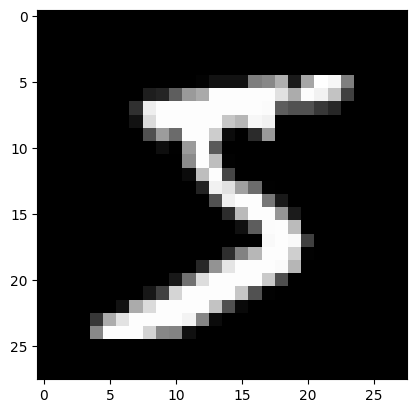

In [26]:
plt.imshow(image.reshape(28,28),cmap="gray")

In [27]:
torch.manual_seed(101)

train_loader=DataLoader(train_data,batch_size=100,shuffle=True)
test_loader=DataLoader(test_data,batch_size=500,shuffle=False)

In [28]:
# Setting the format grid
np.set_printoptions(formatter=dict(int=lambda x:f'{x:4}'))

In [29]:
# A simple techinque is used to load the images and labels for the first batch
# The break statement is used so that the first batch of image is loaded into the variable
for images,labels in train_loader:
  break

In [30]:
#you got the 100 images of size of 28 X 28
print("The shape of the images is ",images.shape)
print("The shape of the labels is ",labels.shape)
print("The first 20 labels i.e the first 20 numbers are :",labels[:20])

The shape of the images is  torch.Size([100, 1, 28, 28])
The shape of the labels is  torch.Size([100])
The first 20 labels i.e the first 20 numbers are : tensor([7, 2, 3, 5, 8, 5, 3, 6, 9, 9, 1, 3, 5, 5, 4, 5, 4, 1, 0, 4])


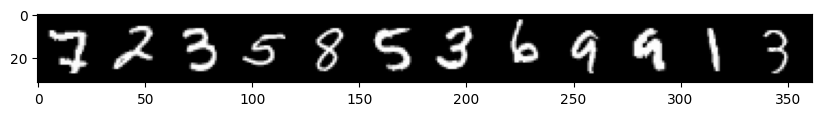

In [31]:
im=make_grid(images[:12],nrow=12)
plt.figure(figsize=(10,4))
# Convert the image tensor to a numpy array and transpose the dimensions to (height, width, channels)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [32]:
class MultiLayerPerception(nn.Module):
  def __init__(self,in_size=784,out_size=10,layers=[120,84]):
    super().__init__()
    self.fc1=nn.Linear(in_size,layers[0])
    self.fc2=nn.Linear(layers[0],layers[1])
    self.out=nn.Linear(layers[1],out_size)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.out(x)

    return F.log_softmax(x,dim=1)


In [33]:
torch.manual_seed(101)
model=MultiLayerPerception()
model

MultiLayerPerception(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
"""
prints the total paramters in the model
94080 is the multiplication of 784x120 where the model has 94080 connections between the input and the first layer
120 nuerons
120 nuerons getting connected to 84 nuerons gets 10080 parameters
..
..
..
"""
for params in model.parameters():
  print(params.numel())

94080
120
10080
84
840
10


In [35]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [36]:
print(images.shape)
#The images cannot be used for training the model so just fltten the images i.e remove the first layer so that the shape becomes(100,784)

torch.Size([100, 1, 28, 28])


In [37]:
images.view(100,-1).shape

torch.Size([100, 784])

In [40]:
start_time=time.time()
epochs=10
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
  trn_crct=0
  test_crct=0
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=model(X_train.view(100,-1))
    loss=criterion(y_pred,y_train)
    predicted=torch.max(y_pred.data,1)[1]
    batch_corr=(predicted==y_train).sum()
    trn_crct+=batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%200==0:
      # accuracy  = trn_crct.item()*100/(100*b)
      print(f"Epoch {i} batch :{b} loss :{loss.item()} accuracy :{trn_crct.item()*100/(100*b):7.3}")

  train_losses.append(loss)
  train_correct.append(trn_crct.item())
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val=model(X_test.view(500,-1))
      predicted=torch.max(y_val.data,1)[1]
      test_crct+=(predicted==y_test).sum()
  loss=criterion(y_val,y_test)
  test_losses.append(loss.item())
  test_correct.append(test_crct.item())

print(b)
total_time=start_time-time.time()
print(f"Total time :{total_time/60} mins")

Epoch 0 batch :200 loss :0.08382391184568405 accuracy :   96.5
Epoch 0 batch :400 loss :0.06502086669206619 accuracy :   96.6
Epoch 0 batch :600 loss :0.06827977299690247 accuracy :   96.7
Epoch 1 batch :200 loss :0.12022455036640167 accuracy :   97.6
Epoch 1 batch :400 loss :0.058163758367300034 accuracy :   97.5
Epoch 1 batch :600 loss :0.03137049823999405 accuracy :   97.5
Epoch 2 batch :200 loss :0.11588415503501892 accuracy :   98.2
Epoch 2 batch :400 loss :0.0415460504591465 accuracy :   98.0
Epoch 2 batch :600 loss :0.048713117837905884 accuracy :   98.0
Epoch 3 batch :200 loss :0.009237682446837425 accuracy :   98.3
Epoch 3 batch :400 loss :0.03706294670701027 accuracy :   98.5
Epoch 3 batch :600 loss :0.058399610221385956 accuracy :   98.4
Epoch 4 batch :200 loss :0.035170312970876694 accuracy :   98.8
Epoch 4 batch :400 loss :0.0613241009414196 accuracy :   98.7
Epoch 4 batch :600 loss :0.09007817506790161 accuracy :   98.7
Epoch 5 batch :200 loss :0.08053234964609146 accurac

In [43]:
np_train_losses = np.array([loss.detach().numpy() for loss in train_losses])
# np_test_losses=np.array([loss.detach().numpy() for loss in test_losses])

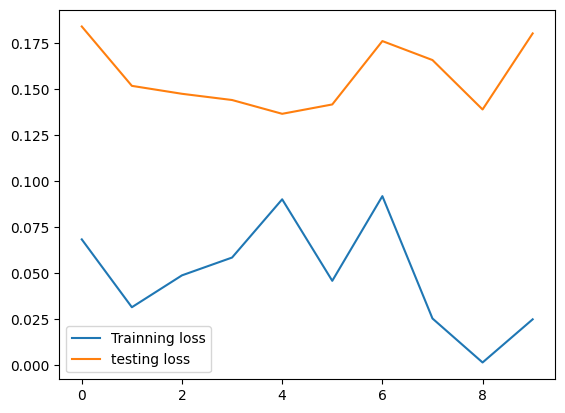

In [44]:
plt.plot(np_train_losses,label="Trainning loss")
plt.plot(test_losses,label="testing loss")
plt.legend()

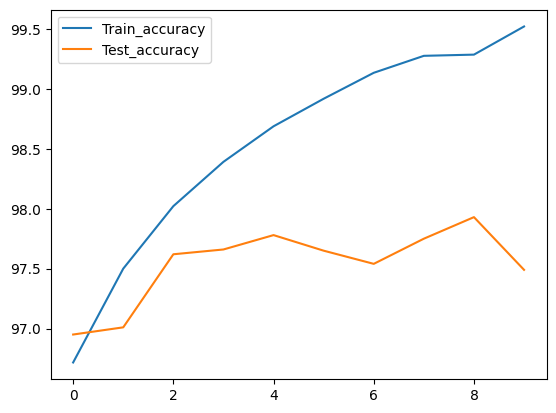

In [50]:
train_Acc=[t/600 for t in train_correct]
test_acc=[t/100 for t in test_correct]
plt.plot(train_Acc,label="Train_accuracy")
plt.plot(test_acc,label="Test_accuracy")
plt.legend()

In [51]:
test_load_all=DataLoader(test_data,batch_size=10000,shuffle=False)
with torch.no_grad():
  correct=0

  for x_test,y_test in test_load_all:
    y_val=model(x_test.view(len(x_test),-1))
    y_pred=torch.max(y_val,1)[1]
    correct+=(y_pred==y_test).sum()

In [52]:
100*correct.item()/len(test_data)

97.49

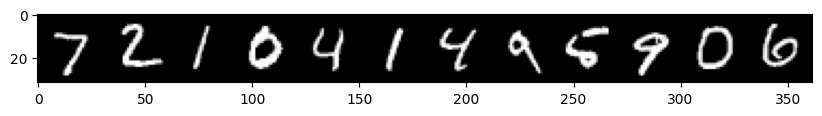

In [55]:
im=make_grid(x_test[:12],nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [75]:
print("The predicted values are :",np.array(y_pred[:12]))

The predicted values are : [   7    2    1    0    4    1    4    9    5    9    0    6]


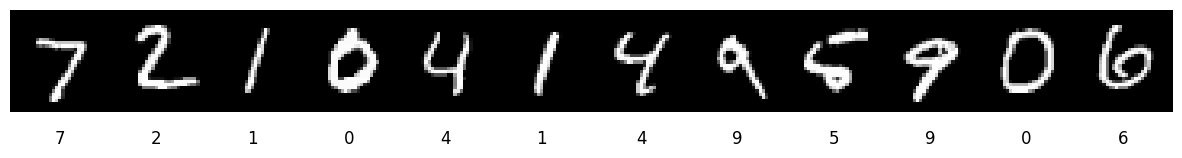

In [81]:
x_test_subset = x_test[:12]
y_pred_subset =np.array(y_pred[:12])
im = make_grid(x_test_subset, nrow=12)
plt.figure(figsize=(15,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
for i in range(12):
    plt.text(i * im.shape[2] // 12 + im.shape[2] // 24, im.shape[1] + 5, str(y_pred_subset[i]),
             ha='center', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.axis('off')
plt.show()